# Prueba post entrenamiento

In [1]:
# import gymnasium as gym
# import sys
# sys.path.append("C:\Users\Kley2\Documents\TFG_2024\Gym_wrapper")
# from learned_pahm import LearnedPAHM

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [3]:
#env = gym.make("Pendulum-v1", g=9.81)
env = gym.make("Pendulum-v1", render_mode="human", g=9.81)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())

# ********************************************************************

def calculate_reward(observ, torque, target_angle): # Todos los valores estan en radianes
    #theta, theta_dot = state
    theta = math.atan2(observ[1],observ[0])
    theta_dot = observ[2]
    
    theta_n = ((theta + np.pi) % (2*np.pi)) - np.pi

    theta_error = np.abs(theta_n - target_angle)
    
    costs = theta_error**2 + 0.1 * theta_dot**2 + 0.001 * (torque**2)

    if theta_error <= 0.26: # ~ 15°
        reward_n = -costs + math.exp(-(theta_error)**2)
    else:
        reward_n = -costs

    return torch.tensor([reward_n], device=device)


True


## Replay Memory

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# class DQN(nn.Module):

#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 128)
#         self.norm1 = nn.LayerNorm(128)    ##
#         self.layer2 = nn.Linear(128, 128)
#         self.norm2 = nn.LayerNorm(128)    ##
#         self.output_layer = nn.Linear(128, n_actions)
#     def forward(self, x):
#         x = F.relu(self.norm1(self.layer1(x)))
#         x = F.relu(self.norm2(self.layer2(x)))
#         #x = F.relu(self.layer1(x))
#         #x = F.relu(self.layer2(x))
#         return self.output_layer(x)
    
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 16)
        self.layer2 = nn.Linear(16, 32)
        self.layer3 = nn.Linear(32, 64)                # Prueba
        self.layer4 = nn.Linear(64, 64)                # Prueba
        self.output_layer = nn.Linear(64, n_actions)
    def forward(self, x):
        x = F.prelu(self.layer1(x), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        x = F.prelu(self.layer2(x), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        x = F.prelu(self.layer3(x), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        x = F.prelu(self.layer4(x), 0.5*torch.rand(1, dtype=torch.float32, device=device))
        #x = F.tanh(self.layer4(x))
        return self.output_layer(x)
        #return self.output_layer(x)*2


In [6]:
BATCH_SIZE = 128    # number of transitions sampled from the replay buffer
GAMMA = 0.99        # discount factor as mentioned in the previous section
EPS_START = 0.9     # starting value of epsilon
EPS_END = 0.05      # final value of epsilon
EPS_DECAY = 1000    # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005         # update rate of the target network
LR = 1e-4           # learning rate of the ``AdamW`` optimizer

# ****************************************************************************
# ****************************************************************************

n_actions = 1

state, info = env.reset()
n_observations = len(state)

# Cargar el modelo
policy_net = DQN(n_observations, n_actions).to(device)
policy_net.load_state_dict(torch.load("models/Pendulum_300eps.pth"))
policy_net.eval()

# ****************************************************************************
# ****************************************************************************

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0
        
episode_rewards = []

def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Time steps (gray lines=episode)')
    plt.ylabel('Reward')
    #plt.plot(rewards_t.numpy(), linewidth=0.2)                 # Cada valor de reward
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())                                 # Promedios del reward

    # Añadir líneas verticales grises en cada t=200
    #for t in range(200, len(rewards_t) + 1, 200):
    #    plt.axvline(x=t, color='gray', linewidth=0.25)

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Complete


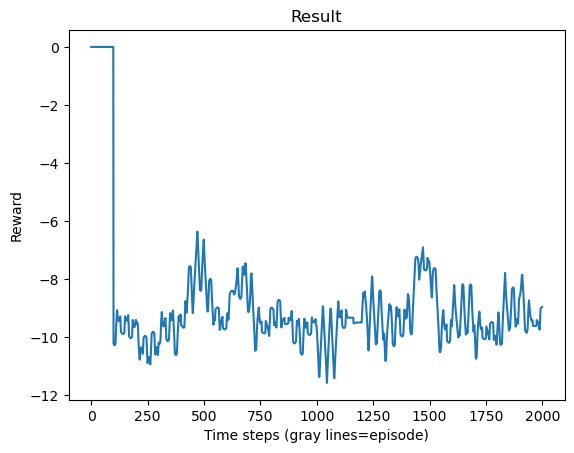

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
## --------------------------------------------------------------------------------------
## --------------------------------------------------------------------------------------

target_angle = 90
#changing_target = False

# ****************************************************************************
num_episodes = 10

## --------------------------------------------------------------------------------------
## --------------------------------------------------------------------------------------

new_rewards = []
epoch = 0

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    print("Episode >> ", i_episode)
    for t in count():
        with torch.no_grad():
            subaction = policy_net(state).item()
        action = np.array([subaction], dtype=np.float32) # Se cambio select_action() por policy_net()
        observation, reward, terminated, truncated, _ = env.step(action)

        # ///////////////////////////////////////////////////////////////////////////////////////////////////
        reward = calculate_reward(observation, action.item(), math.radians(target_angle))
        # ///////////////////////////////////////////////////////////////////////////////////////////////////

        done = terminated or truncated

        ## *********************************************************************************
        pole_angle = math.degrees(math.atan2(observation[1],observation[0]))

        #vala = state[0].cpu().numpy()
        #print(vala)
        print(np.array([pole_angle, action.item(), reward.item()]))
        new_rewards.append(reward.item())
        ## *********************************************************************************

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state       

        if done:
            episode_rewards = episode_rewards + new_rewards
            new_rewards = []
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()
env.close()